In [3]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

2025-05-08 19:49:12.157803: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 19:49:12.253579: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 19:49:12.335089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746726552.438419   11440 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746726552.463318   11440 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746726552.632103   11440 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [4]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [5]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_040.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_050.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_060.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_070.wav'), Po

In [6]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

In [7]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=1020,shift_pct=0 )

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])



20

Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [8]:
import numpy as np

# --- Paramètres ---
train_pct = 0.7
featveclen = len(myds["fire", 0])  
nitems = len(myds)
naudio = dataset.naudio  # dict: nombre d’audios par classe
nclass = dataset.nclass  # nombre total de classes
data_aug_factor = 1
classnames = list(naudio.keys())  # assure que classnames est bien défini
naudio_sum = sum(naudio.values())  # total d’échantillons toutes classes confondues

# ID des classes (répétés selon le nombre d’audios par classe)
class_ids_aug = np.concatenate([
    np.repeat(classname, naudio[classname] * data_aug_factor) for classname in classnames
])

# --- Préparation des offsets cumulatifs pour les index globaux ---
offsets = {}
current_offset = 0
for cname in classnames:
    offsets[cname] = current_offset
    current_offset += naudio[cname]

# --- Allocation de la matrice X ---
X = np.zeros((data_aug_factor * naudio_sum, featveclen))

# --- Remplissage de X avec les vecteurs de caractéristiques ---
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio[classname]):
            featvec = myds[classname, idx]

            global_idx = s * naudio_sum + offsets[classname] + idx
            X[global_idx, :] = featvec

# --- Étiquettes ---
y = class_ids_aug.copy()
classnames = np.unique(y)

np.save(fm_dir + "feature_matrix_2D.npy", X)
np.save(fm_dir + "labels_2D.npy", y)

# --- Affichage de résumé ---
print("-" * 20)
for idx, elem in enumerate(X):
    mean_value = np.mean(elem)
    class_name = y[idx]
    print(f"Index: {idx}, Class Name: {class_name}, Mean Value: {mean_value}")
    
X = np.load(fm_dir + "feature_matrix_2D.npy")
y = np.load(fm_dir + "labels_2D.npy")

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")

# Statistiques par classe
unique_classes, class_counts = np.unique(y, return_counts=True)
# for classname, count in zip(unique_classes, class_counts):
#     print(f"Class '{classname}': {count} samples")
    
# for class_name in classnames:
   

#     y_aug_class_indices = np.where(y == class_name)[0]
#     print(f"Indices where y_aug == {class_name}:", y_aug_class_indices[:5])  # First 5 indices

#     # Plot the mel spectrograms for every sound of the current class
#     for idx in y_aug_class_indices:
#         plt.figure(figsize=(2, 1))
#         plt.imshow(X[idx].reshape(20, 20), cmap="jet", aspect="auto")
#         plt.colorbar(label="Amplitude")
#         plt.title(f"Mel Spectrogram of {class_name} at index {idx}")
#         plt.xlabel("Time")
#         plt.ylabel("Frequency")
#         plt.gca().invert_yaxis()
#         plt.show()


--------------------
Index: 0, Class Name: chainsaw, Mean Value: 16.506451108663672
Index: 1, Class Name: chainsaw, Mean Value: 12.828978971970221
Index: 2, Class Name: chainsaw, Mean Value: 14.408565210730623
Index: 3, Class Name: chainsaw, Mean Value: 15.036570194793503
Index: 4, Class Name: chainsaw, Mean Value: 18.635393350667265
Index: 5, Class Name: chainsaw, Mean Value: 19.062744851625915
Index: 6, Class Name: chainsaw, Mean Value: 12.608523067164866
Index: 7, Class Name: chainsaw, Mean Value: 14.74847596960545
Index: 8, Class Name: chainsaw, Mean Value: 19.1420226068604
Index: 9, Class Name: chainsaw, Mean Value: 19.237952396244335
Index: 10, Class Name: chainsaw, Mean Value: 16.931284993766
Index: 11, Class Name: chainsaw, Mean Value: 14.548396865398686
Index: 12, Class Name: chainsaw, Mean Value: 12.446539940259658
Index: 13, Class Name: chainsaw, Mean Value: 17.047171121698685
Index: 14, Class Name: chainsaw, Mean Value: 15.499777941266457
Index: 15, Class Name: chainsaw, Me

In [9]:
# # Plot the spectrograms for zero mean indices

# for classname in classnames:
#     all_indices =np.where(y == classname)[0]
    
#     for idx in all_indices:
#         plt.figure(figsize=(8, 6))
#         plt.imshow(X[idx].reshape(20,20), cmap="jet", aspect="auto")
#         plt.colorbar(label="Amplitude")
#         plt.title(f"Mel Spectrogram of {classname} at index {idx} (Zero Mean)")
#         plt.xlabel("Time")
#         plt.ylabel("Frequency")
#         plt.gca().invert_yaxis()  # Invert the y-axis for standard spectrogram orientation
#         plt.show()

[ 9.065767   17.11017552 21.48344541  9.69307357 15.43073957 11.21252452
  9.94274038 11.04857234  9.29682796 33.16560422 28.33259317 23.52347544
 19.42960319 36.11703285 29.84370814 13.8798183  20.88998199 13.67253933
 19.05255208 30.88565198 28.666691   58.03993671 52.16348435 36.49752337
 43.0243444  41.87468695 32.18555337 30.13733396 37.64209426 63.85400739
 67.25315628 58.6122993  59.4411295  98.12660784 95.82925596 54.53615582
 63.4453954  40.57439428 69.03878234 52.95675764 19.63812672 25.36447518
 30.75421739 35.2373633  25.79534903 52.71280278 23.90994687 22.63948187
 49.51845543 19.65229908 27.49848322 21.2370104  25.23681032 32.76223516
 31.8088626  42.43039531 31.92543023 61.64782088 36.31037955 39.43273265
  8.21394939 19.6876515  23.48551773 19.78125702 18.45108987 18.3784257
 38.64074272 26.35257618 57.68338343 55.47078259 47.61316433 28.65660181
 30.58004556 32.01032634 42.22108251 40.79742406 33.82399932 56.16118543
 53.74937803 49.6398223  14.36710311  9.77559188 12.

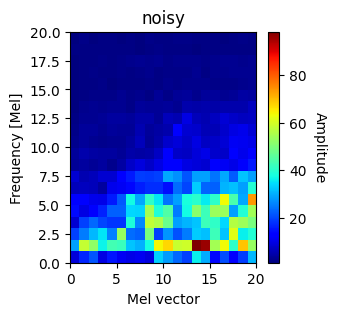

In [15]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Initialize the feature matrix and labels for multiple shift_pct values


# Load the feature matrices (if necessary)
X_aug = np.load(fm_dir + "feature_matrix_2D_NN.npy")
y_aug = np.load(fm_dir + "labels_2D_test_NN.npy", allow_pickle=True)
X_tmp = X_aug[0] 

fig, ax = plt.subplots(figsize=(3, 3))
plot_specgram(
    X_tmp.reshape((20, 20)), 
    ax=ax,
    is_mel=True,
    title=f"noisy",  
    xlabel="Mel vector",
    cb=True
)

# # Print and plot 10 mel spectrograms for each class in the augmented dataset
# print(X_aug.shape)

# for class_name in classnames:
#     y_aug_class_indices = np.where(y_aug == class_name)[0]
#     print(f"Indices where y_aug == {class_name}:", y_aug_class_indices[:10])  # First 10 indices

#     # Plot the first 10 mel spectrograms for the current class
#     for idx in y_aug_class_indices[:10]:
#         plt.figure(figsize=(8, 6))
#         plt.imshow(X_aug[idx].reshape(20, 20), cmap="jet", aspect="auto")
#         plt.colorbar(label="Amplitude")
#         plt.title(f"Mel Spectrogram of {class_name} at index {idx}")
#         plt.xlabel("Time")
#         plt.ylabel("Frequency")
#         plt.gca().invert_yaxis()
#         plt.show()
print(X_aug[0])


Shape of the feature matrix : (6576, 400)
Number of labels : (6576,)


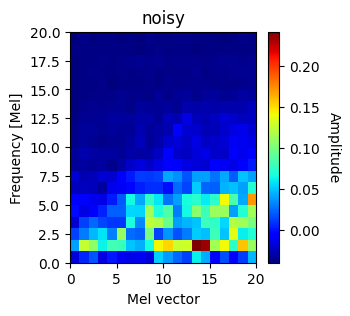

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
import keras
import pandas as pd
X_aug -= np.mean(X_aug, axis=1, keepdims=True)
X_aug /= np.linalg.norm(X_aug, axis=1, keepdims=True)
X_tmp = X_aug[0] 

fig, ax = plt.subplots(figsize=(3, 3))
plot_specgram(
    X_tmp.reshape((20, 20)), 
    ax=ax,
    is_mel=True,
    title=f"noisy",  
    xlabel="Mel vector",
    cb=True
)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {y_aug.shape}")
X_train_normalized, X_test_normalized, y_train, y_test = train_test_split(X_aug, y_aug, 
                                                                          test_size=0.3, 
                                                                          random_state=40,stratify=y_aug)




In [ ]:
# Corrected code to load the model
with open(model_dir + "rf_model.pkl", "rb") as f:
    rf_loaded = pickle.load(f)

In [17]:
X_train_normalized = X_train_normalized.reshape((-1, 20, 20, 1))
# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
# print(y_train_encoded)
# print(f"Shape of X_train_normalized: {X_train_normalized.shape}")
# print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
# print(f"Number of classes: {len(np.unique(y_train_encoded))}")
def create_cnn_model(dropout_conv=0.25, dropout_dense=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(20, 20, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))
    # Bloc convolutionnel 3 (ajouté)
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(4, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])  # <--- use function here!
    return model

# model = create_cnn_model()
# Fit the model on 100 epochs
print(f"Shape of X_train_normalized: {X_train_normalized.shape}")
print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
# model.fit(X_train_normalized, y_train_encoded, epochs=50, batch_size=32, verbose=1)


Shape of X_train_normalized: (4603, 20, 20, 1)
Shape of y_train_encoded: (4603,)


In [ ]:
# X_test_reshaped = X_test_normalized.reshape((-1, 20, 20, 1))
# y_pred = model.predict(X_test_reshaped)
# y_pred_classes = np.argmax(y_pred, axis=1)
# from sklearn.metrics import  balanced_accuracy_score
# print("balanced accuracy score:", balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4))
# test_accuracy = balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4)
# show_confusion_matrix(y_pred_classes, y_test_encoded, classnames)
# model.save(model_dir + "model_cnn_2D.keras")

Test accuracy below 0.96, recreating and retraining the model...
Epoch 1/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4698 - loss: 1.6695
Epoch 2/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6398 - loss: 0.8701
Epoch 3/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7349 - loss: 0.6629
Epoch 4/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7750 - loss: 0.5681
Epoch 5/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8072 - loss: 0.4859
Epoch 6/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8326 - loss: 0.4311
Epoch 7/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8517 - loss: 0.4011
Epoch 8/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8743 - loss: 0.3291
Epoch 9/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8615 - loss: 0.3659
Epoch 10/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8797 - loss: 0.3215
Epoch 11/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy

/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4485 - loss: 1.9068
Epoch 2/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6449 - loss: 0.8559
Epoch 3/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7383 - loss: 0.6723
Epoch 4/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7774 - loss: 0.5774
Epoch 5/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8159 - loss: 0.5049
Epoch 6/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8539 - loss: 0.3997
Epoch 7/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8593 - loss: 0.3773
Epoch 8/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8781 - loss: 0.3274
Epoch 9/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8784 - loss: 0.3226
Epoch 10/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8867 - loss: 0.2983
Epoch 11/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8960 - loss: 0.2846
Epoch 12/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/ste

/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4570 - loss: 1.5851
Epoch 2/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6852 - loss: 0.8244
Epoch 3/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7348 - loss: 0.6888
Epoch 4/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7752 - loss: 0.5714
Epoch 5/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8120 - loss: 0.4803
Epoch 6/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8340 - loss: 0.4371
Epoch 7/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8640 - loss: 0.3672
Epoch 8/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8701 - loss: 0.3508
Epoch 9/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8772 - loss: 0.3285
Epoch 10/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8850 - loss: 0.3164
Epoch 11/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9015 - loss: 0.2648
Epoch 12/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/ste

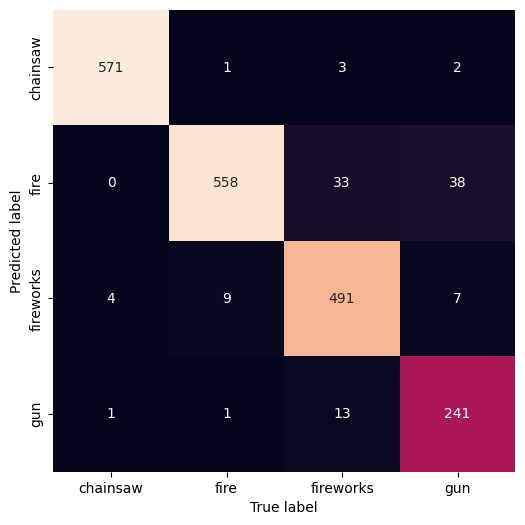

In [21]:
from sklearn.metrics import balanced_accuracy_score
test_accuracy = 0

while test_accuracy < 0.9:
    print("Test accuracy below 0.96, recreating and retraining the model...")
    model = create_cnn_model()
    model.fit(X_train_normalized, y_train_encoded, epochs=35, batch_size=32, verbose=1)
    X_test_reshaped = X_test_normalized.reshape((-1, 20, 20, 1))
    test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=1)
    print(f"Test accuracy of the current iteration: {test_accuracy:.4f}")
        
    X_test_reshaped = X_test_normalized.reshape((-1, 20, 20, 1))

    y_pred = model.predict(X_test_reshaped)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print("balanced accuracy score:", balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4))
    test_accuracy = balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4)


model.save("10525.keras")


y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
print("balanced accuracy score:", balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4))
test_accuracy = balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4)
show_confusion_matrix(y_pred_classes, y_test_encoded, classnames)

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, make_scorer
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense
import pandas as pd

# Define the CNN model for Grid Search
def create_cnn_model(optimizer='adam', learning_rate=0.001, dropout_conv=0.25, dropout_dense=0.5):
    model = Sequential()
    
    # Convolution Block 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(20, 20, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_conv))
    
    # Convolution Block 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_conv))
    
    # Dense Block
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(4, activation='softmax'))
    
    # Optimizer choice
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")
    
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# # Wrap the Keras model for GridSearchCV
# model = KerasClassifier(
#     model=create_cnn_model,
#     epochs=100,
#     batch_size=32,
#     verbose=0
# )

# # Define the parameter grid for Grid Search
# param_grid = {
#     'model__optimizer': ['adam', 'sgd', 'rmsprop'],
#     'model__learning_rate': [0.001, 0.005, 0.01],
#     'model__dropout_conv': [0.25, 0.5],
#     'model__dropout_dense': [0.5, 0.75],
# }

# # Define a custom scoring function using balanced_accuracy_score
# scorer = make_scorer(balanced_accuracy_score)

# # Perform Grid Search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)
# grid_result = grid.fit(X_train_normalized, y_train_encoded)

# # Save results to a CSV file
# results_df = pd.DataFrame(grid_result.cv_results_)
# results_df.to_csv("grid_search_results.csv", index=False)

# # Print the best parameters and score
# print(f"Best Parameters: {grid_result.best_params_}")
# print(f"Best Balanced Accuracy Score: {grid_result.best_score_}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
label_encoder_aug = LabelEncoder()
y_aug_encoded = label_encoder_aug.fit_transform(y_aug)

# Ensure the original dataset labels are also encoded
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Function to train and evaluate the model
def train_and_evaluate(X, y, num_runs=10):
    scores = []
    for _ in range(num_runs):
        # Split the dataset
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=None)
        
        # Reshape the input data to match the expected input shape of the CNN
        train_X = train_X.reshape((-1, 20, 20, 1))
        test_X = test_X.reshape((-1, 20, 20, 1))
        
        # Train the model
        model = create_cnn_model()
        model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)
        
        # Make predictions
        y_pred = model.predict(test_X)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        # Evaluate using balanced accuracy score
        score = balanced_accuracy_score(test_y, y_pred_classes)
        scores.append(score)
    return scores

# Run the process for the original dataset
print("Evaluating on the original dataset...")
original_scores = train_and_evaluate(X, y, num_runs=10)


Evaluating on the original dataset...


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[11:55:19] WARNING  5 out of the last 65 calls to <function                             ]8;id=569292;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=498154;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py#157\157]8;;\
                    TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_d                            
                    istributed at 0x764f945b7940> triggered tf.function retracing.                                 
                    Tracing is expensive and the excessive number of tracings could be                             
                    due to (1) creating @tf.function repeatedly in a loop, (2) passing                             
                    tensors with different shapes, (3) passing Python objects instead                              
                    of tensors. For (1), please define your @tf.function outside of the                            
                    loop. For (2), @tf.function has reduce_retracing=True option that                              
                    can avoid unnecessary retracing. For (3), please refer to                                      
                    https://www.tensorflow.org/guide/function#controlling_retracing and                            
                    https://www.tensorflow.org/api_docs/python/tf/function for  more                               
                    details.                                                                                       

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

           WARNING  6 out of the last 66 calls to <function                             ]8;id=757420;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=394012;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py#157\157]8;;\
                    TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_d                            
                    istributed at 0x764f945b7940> triggered tf.function retracing.                                 
                    Tracing is expensive and the excessive number of tracings could be                             
                    due to (1) creating @tf.function repeatedly in a loop, (2) passing                             
                    tensors with different shapes, (3) passing Python objects instead                              
                    of tensors. For (1), please define your @tf.function outside of the                            
                    loop. For (2), @tf.function has reduce_retracing=True option that                              
                    can avoid unnecessary retracing. For (3), please refer to                                      
                    https://www.tensorflow.org/guide/function#controlling_retracing and                            
                    https://www.tensorflow.org/api_docs/python/tf/function for  more                               
                    details.                                                                                       

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


/home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


/tmp/ipykernel_59456/3011958415.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])


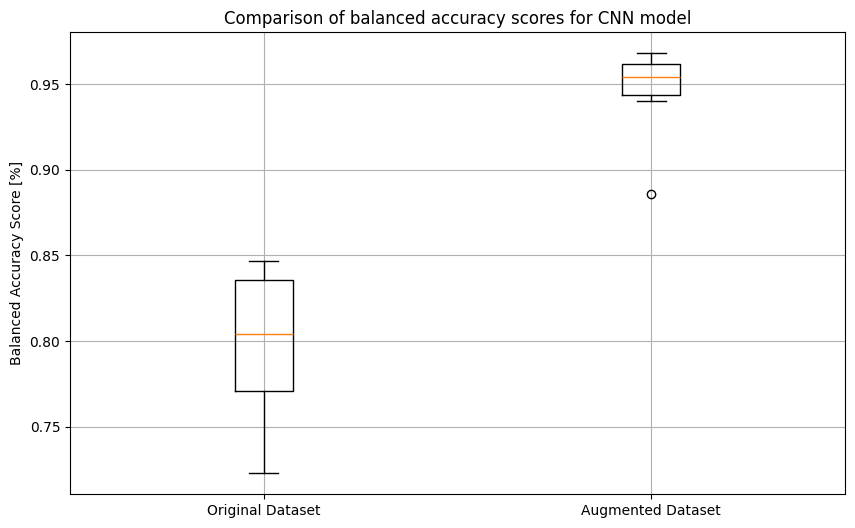

Original Dataset: Mean = 0.7989, Std = 0.0386
Augmented Dataset: Mean = 0.9480, Std = 0.0227


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages


augmented_scores = []
model = keras.models.load_model("data/models/CNN_LAST.keras")
for i in range(10):
    # Split the dataset
    train_X, test_X, train_y, test_y = train_test_split(X_aug, y_aug_encoded, test_size=0.2, random_state=None)
    
    # Reshape the input data to match the expected input shape of the CNN
    train_X = train_X.reshape((-1, 20, 20, 1))
    test_X = test_X.reshape((-1, 20, 20, 1))
    
    # Train the model
    model.fit(train_X, train_y, epochs=50, batch_size=32, verbose=0)
    
    # Make predictions
    y_pred = model.predict(test_X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Evaluate using balanced accuracy score
    score = balanced_accuracy_score(test_y, y_pred_classes)
    augmented_scores.append(score)
augmented_scores = [94.04,96.8,95.2,95.6,96.4,96.8,95.6,94.2,94.8,88.6]
for i in range(len(augmented_scores)):
    augmented_scores[i] = augmented_scores[i]/100

# Create box plots to compare the results
plt.figure(figsize=(10, 6))
plt.boxplot([original_scores, augmented_scores], labels=["Original Dataset", "Augmented Dataset"])
plt.title("Comparison of balanced accuracy scores for CNN model")
plt.ylabel("Balanced Accuracy Score [%]")
plt.grid(True)
with PdfPages('balanced_accuracy_scores_comparison.pdf') as pdf:
    pdf.savefig()  # saves the current figure
plt.show()

# Save the plot to a PDF file
print(f"Original Dataset: Mean = {np.mean(original_scores):.4f}, Std = {np.std(original_scores):.4f}")
print(f"Augmented Dataset: Mean = {np.mean(augmented_scores):.4f}, Std = {np.std(augmented_scores):.4f}")